<h1>Capstone Project - Interim Report</h1>

<h3>Problem</h3>

<p>Many of today's fantasy sports toolkits use average points scored to help predict out points. They typically show the following averages to show case how a player is trending and how many points a player will score in the short term:
<br>
- 3 Game Rolling Average
<br>
- 7 Game Rolling Average
<br>
- Year-to-Date Average
</p>

<p>Our goal for this project is to come up with a machine learning algorithm that can predict points better than these averages. </p>

<h3>Dataset</h3>

<p>NBA keeps a log of all their statistical outputs on an API. Fortunately for us as well, there exists a Python library that acts as a CLI to the API. Unfortunately for us, there also exists limitations to the number of HTTP requests made to the API. Thus we cannot scrape specific details on the line up for the game, whether a player is a bonafide starter or does a player play shooting guards more or plays point guard more. The most detail we can get to a player is to have a game log of their statistics for each game (e.g. minutes played, points scored, blocks, assists, etc.). We will then have to make some assumptions on the data to fill in certain variables we deem to be necessary.</p>

<p>We'll be using two main modules from the NBA_py CLI.
<br>
- PlayerStats: used to filter out players who we do not want to skew the data (i.e. players who play fewer than 30 games and play less than 15 minutes).
<br>
- GameLog: we have the option here to select gamelogs for teams or for players. We will be querying teams stats because how a team is trending in defensive rating. We will also be querying player game logs obviously because we will be using the bulk of past statistics to predict out the points they scored in that specific game!
</p>
<p>
We will be using the following years of data for our training set: 2014-15, 2015-16, 2016-17. We will be using the 2017-18 season as our test set.

Please see below for examples of GameLog and PlayerStats.
</p>

In [27]:
from IPython.display import Math
from nba_py.league import GameLog, PlayerStats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
pd.options.mode.chained_assignment = None  # default='warn'

In [11]:
GameLog(season='2014-15', player_or_team='P').overall().head()

,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22014,202681,Kyrie Irving,1610612739,CLE,Cleveland Cavaliers,0021400964,2015-03-12,CLE @ SAS,W,...,2,3,5,4,0,2,3,57,5,1
1,22014,202681,Kyrie Irving,1610612739,CLE,Cleveland Cavaliers,0021400681,2015-01-28,CLE vs. POR,W,...,2,4,5,2,0,3,0,55,12,1
2,22014,201566,Russell Westbrook,1610612760,OKC,Oklahoma City Thunder,0021401197,2015-04-12,OKC @ IND,L,...,8,9,8,1,0,2,5,54,-4,1
3,22014,202691,Klay Thompson,1610612744,GSW,Golden State Warriors,0021400651,2015-01-23,GSW vs. SAC,W,...,2,2,5,4,2,4,3,52,38,1
4,22014,2590,Mo Williams,1610612750,MIN,Minnesota Timberwolves,0021400567,2015-01-13,MIN @ IND,W,...,4,4,7,0,0,3,2,52,14,1


In [10]:
PlayerStats(season='2014-15', starter_bench='Starters', player_position='C').overall().head()

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,...,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,CFID,CFPARAMS
0,203940,Adreian Payne,1610612750,MIN,24.0,22,2,20,0.091,26.1,...,62,25,75,59,88,78,40,3,5,"203940,1610612750"
1,201143,Al Horford,1610612737,ATL,29.0,76,56,20,0.737,30.5,...,60,87,66,13,12,14,24,2,5,"201143,1610612737"
2,2744,Al Jefferson,1610612766,CHA,30.0,61,22,39,0.361,31.0,...,19,69,49,8,56,13,13,3,5,"2744,1610612766"
3,203458,Alex Len,1610612756,PHX,22.0,44,23,21,0.523,24.2,...,62,22,69,71,35,46,30,3,5,"203458,1610612756"
4,201582,Alexis Ajinca,1610612740,NOP,27.0,8,2,6,0.250,21.6,...,57,25,36,45,54,69,53,3,5,"201582,1610612740"


<p>Note that in the PlayerStats query, we have the option of choosing starters or bench. This query will show the players season statistics for games where they were a starter or bench player depending on the option selected.</p>
<p>We will run the query twice for each season for both starter and bench. We will then merge the dataset together on the 'PLAYER_ID' column and compare the 'GP' column for both starters and bench. We will then divide the starter_GP with the sum of starter_GP and bench_GP. This will then give us a percentage for how often a player starts. We would suspect starters to have a higher mean points scored and may have to be analyzed differently.</p>
<p>You will also note that we can query on player positions. We can query on forwards, guards and centers (not as specific as we would like - there are 2 different guard positions and 2 different forward positions). We'll create a new column here to highlight the different positions.</p>
<p>We may also need to look at the team's pace. We will use the NBA's official PACE calculator formula per the below.</p>

In [12]:
Math(r'PACE = FGA + 0.4 * FTA - 1.07  (FGA-FGM)\frac{OREB}{OREB + OPPDREB} + TOV')

<IPython.core.display.Math object>

<p>We will combine all this data into one file for us to begin our EDA analysis.</p>

<h3>Exploratory Data Analysis</h3>

<p>Let's start by loading in the cleaned data.</p>

In [19]:
seasons = ['2014-15','2015-16','2016-17']
test_set = '2017-18'
df = pd.DataFrame()
for year in seasons:
    temp_df = pd.read_csv("../raw_data/eda_data"+year+".csv")
    df = pd.concat([df, temp_df])

df.head()

,Unnamed: 0,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,FORWARD,GUARD,STARTER_GAMES,BENCH_GAMES,TOTAL_GAMES,PERCENT_STARTS,STARTER,SEASON,FG2M,FG2A
0,0,708,Kevin Garnett,1610612751,BKN,Brooklyn Nets,21400006,2014-10-29,BKN @ BOS,L,...,F,NaN,47.0,0.0,47.0,1.0,YES,2014-15,5,8
1,1,708,Kevin Garnett,1610612751,BKN,Brooklyn Nets,21400033,2014-11-01,BKN @ DET,W,...,F,NaN,47.0,0.0,47.0,1.0,YES,2014-15,7,15
2,2,708,Kevin Garnett,1610612751,BKN,Brooklyn Nets,21400044,2014-11-03,BKN vs. OKC,W,...,F,NaN,47.0,0.0,47.0,1.0,YES,2014-15,3,8
3,3,708,Kevin Garnett,1610612751,BKN,Brooklyn Nets,21400060,2014-11-05,BKN vs. MIN,L,...,F,NaN,47.0,0.0,47.0,1.0,YES,2014-15,1,7
4,4,708,Kevin Garnett,1610612751,BKN,Brooklyn Nets,21400075,2014-11-07,BKN vs. NYK,W,...,F,NaN,47.0,0.0,47.0,1.0,YES,2014-15,2,3


Let's start by analyzing the percentage of starts and how we should be categorizing them.

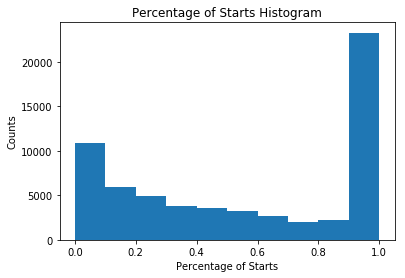

In [22]:
starts = plt.hist(df['PERCENT_STARTS'])
starts = plt.xlabel('Percentage of Starts')
starts = plt.ylabel('Counts')
starts = plt.title('Percentage of Starts Histogram')
plt.show()

<p>We can see here that a large portion of the observations have are between 90% - 100%. It is save to assume that players who start 90% to 100% of the time are starters. To be on the safe side, we'll say players who start 80% of the time or more are starters.</p>
<p>We will also say that players who start less than 20% of the time are for sure bench players. Anything in between this, we will say are 'tweeners'.</p>
<p>Now that we have these categories resolved, let's analyze the boxplots to see if there are any differences in the mean.</p>

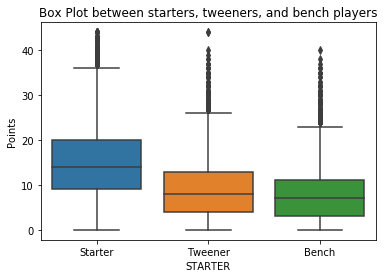

In [25]:
starters = df[df['STARTER'] == 'YES'].assign(STARTER='Starter')
starters  = starters [starters ['PTS'] < 45]
in_between = df[df['STARTER'] == 'IN_BETWEEN'].assign(STARTER='Tweener')
in_between = in_between[in_between['PTS'] < 45]
bench = df[df['STARTER'] == 'NO'].assign(STARTER='Bench')
bench = bench[bench['PTS'] < 45]
cdf = pd.concat([starters, in_between, bench]) 
mdf = pd.melt(cdf, id_vars=['STARTER'], value_vars=['PTS'], var_name=['PTS'])
ax = sns.boxplot(x="STARTER", y="value", data=mdf)
ax = plt.title('Box Plot between starters, tweeners, and bench players')
ax = plt.ylabel('Points')
plt.show()

<p>We can see that there is a definite difference for starter players. There is not much of a difference between tweeners and bench players</p>

<p>We may tweak our rule later on but for now, this rule should be a good rule of thumb for now.</p>

<p>Now let's start analyzing the different positions.</p>

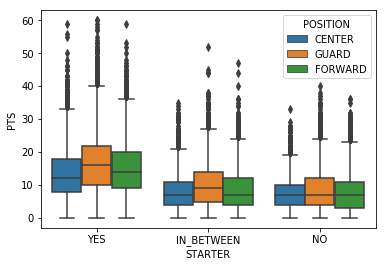

In [28]:
centers = df.loc[df.CENTER.notnull()]
centers['POSITION'] = 'CENTER'
centers = centers[['POSITION','STARTER','PTS','FG2M', 'FG2A', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB','REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS' ]]
guards = df[df.GUARD.notnull()]
guards['POSITION'] = 'GUARD'
guards = guards[['POSITION','STARTER','PTS','FG2M', 'FG2A', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB','REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS' ]]
forwards = df[df.FORWARD.notnull()]
forwards['POSITION'] = 'FORWARD'
forwards = forwards[['POSITION','STARTER','PTS','FG2M', 'FG2A', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB','REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS' ]]

all_players = pd.concat([centers, guards, forwards])
boxplot_data = all_players[['POSITION','STARTER', 'PTS']]
axs = sns.boxplot(x='STARTER', y='PTS', data=boxplot_data, hue='POSITION')

<p>We can see that between each of the three positions, it looks like there is practically no difference in the trends between starters, tweeners and bench players. Across all three categories, we see that centers score more points, forwards score the next most and then guards. Just to be safe however, we'll start looking at the correlations for all 6 combinations and how they relate to points.</p>

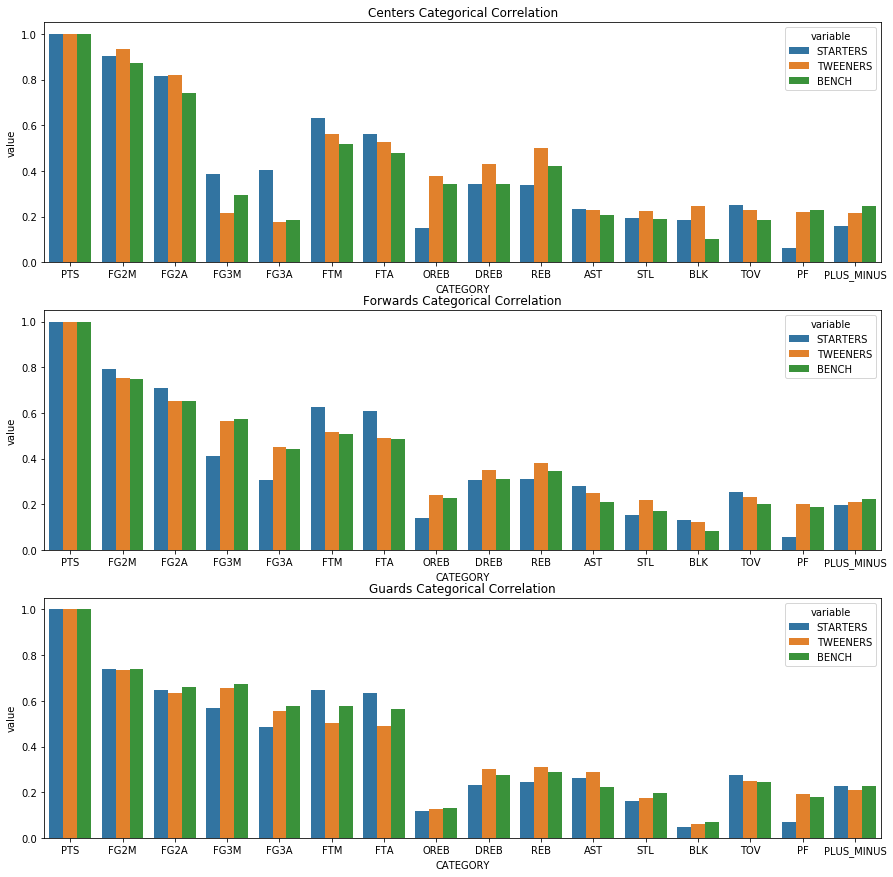

In [29]:
sc_corr = centers[centers['STARTER']=='YES'].corr()
sf_corr = forwards[forwards['STARTER']=='YES'].corr()
sg_corr = guards[guards['STARTER']=='YES'].corr()

tc_corr = centers[centers['STARTER']=='IN_BETWEEN'].corr()
tf_corr = forwards[forwards['STARTER']=='IN_BETWEEN'].corr()
tg_corr = guards[guards['STARTER']=='IN_BETWEEN'].corr()

bc_corr = centers[centers['STARTER']=='NO'].corr()
bf_corr = forwards[forwards['STARTER']=='NO'].corr()
bg_corr = guards[guards['STARTER']=='NO'].corr()

columns = ['STARTERS', 'TWEENERS', 'BENCH','CATEGORY']
centers_corr = pd.concat([sc_corr['PTS'],tc_corr['PTS'], bc_corr['PTS']],axis=1, ignore_index=True)
centers_corr['CATEGORY'] = centers_corr.index
centers_corr.columns = columns
mcenters_corr = pd.melt(centers_corr, id_vars='CATEGORY', value_vars=['STARTERS', 'TWEENERS', 'BENCH'])

forwards_corr = pd.concat([sf_corr['PTS'],tf_corr['PTS'], bf_corr['PTS']],axis=1,ignore_index=True)
forwards_corr['CATEGORY'] = forwards_corr.index
forwards_corr.columns = columns
mforwards_corr = pd.melt(forwards_corr, id_vars='CATEGORY', value_vars=['STARTERS', 'TWEENERS', 'BENCH'])

guards_corr = pd.concat([sg_corr['PTS'],tg_corr['PTS'], bg_corr['PTS']],axis=1,ignore_index=True)
guards_corr['CATEGORY'] = guards_corr.index
guards_corr.columns = columns
mguards_corr = pd.melt(guards_corr, id_vars='CATEGORY', value_vars=['STARTERS', 'TWEENERS', 'BENCH'])

fig, axs = plt.subplots(nrows=3,figsize=(15,15))
c = sns.barplot(x='CATEGORY', y='value', data=mcenters_corr, ax=axs[0], hue='variable')
c.set_title('Centers Categorical Correlation')
f = sns.barplot(x='CATEGORY', y='value', data=mforwards_corr, ax=axs[1], hue='variable')
f.set_title('Forwards Categorical Correlation')
g = sns.barplot(x='CATEGORY', y='value', data=mguards_corr, ax=axs[2], hue='variable')
g.set_title('Guards Categorical Correlation')
plt.show()

<p>We can see that the shooting categories have a high correlation with points - this is to be expected since they all directly impact how many points a player scores. Thus these are independent variables that we will be including. To reiterate, these are the 'FG2M', 'FG2A', 'FG3M', 'FG3A', 'FTM' and 'FTA' categories.

We also see that centers are unique - particularly tweeners and bench players. We see that rebounds have a significant correlation here. This makes sense as tweeners and bench players are sometimes viewed as "energy" players. Thus players who are more active and engaged in the plays may have more points.</p>

In [30]:
centers_corr[centers_corr>0.4].drop(['CATEGORY'], axis=1).dropna(how='all')

,STARTERS,TWEENERS,BENCH
PTS,1.000000,1.000000,1.000000
FG2M,0.905352,0.935912,0.871080
FG2A,0.816123,0.819353,0.739827
FG3A,0.403834,NaN,NaN
FTM,0.632582,0.561227,0.519079
FTA,0.562921,0.528676,0.479689
DREB,NaN,0.430423,NaN
REB,NaN,0.498834,0.423683


In [31]:
forwards_corr[forwards_corr>0.4].drop(['CATEGORY'], axis=1).dropna(how='all')

,STARTERS,TWEENERS,BENCH
PTS,1.000000,1.000000,1.000000
FG2M,0.794712,0.751462,0.750145
FG2A,0.707861,0.654408,0.654406
FG3M,0.410329,0.565089,0.571902
FG3A,NaN,0.452904,0.441151
FTM,0.625708,0.515147,0.509840
FTA,0.610783,0.489974,0.487132


In [32]:
guards_corr[guards_corr>0.4].drop(['CATEGORY'], axis=1).dropna(how='all')

,STARTERS,TWEENERS,BENCH
PTS,1.000000,1.000000,1.000000
FG2M,0.739214,0.733457,0.737895
FG2A,0.645899,0.633492,0.658485
FG3M,0.569599,0.655368,0.675053
FG3A,0.487489,0.555191,0.578872
FTM,0.645509,0.504038,0.575893
FTA,0.635172,0.490521,0.566108


<p>In this section we've analyzed done the first EDA to see what categories to be included in the EDA on a player level. We've narrowed down the categories to the following: 
- Categorical Data: Player Position, Team playing against, Home vs Away, Game Number 
- Statistical Data: FG2M, FG2A, FG3M, FG3A, FTM, FTA 
We will also need to be completing a secondary EDA on the rolling averages of each past game to see if there is a statistical significance in the different rolling window we use to predict out the points scored using past data.</p>

<p>Let's also begin analyzing to see if there is a trend for players scoring depending on the game they play in that season. Note that there are 82 games.</p>

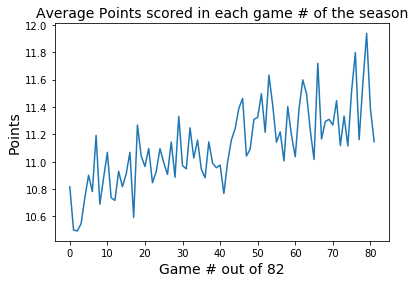

In [20]:
_ = plt.plot(df[['GAME_NUMBER', 'PTS']].groupby(['GAME_NUMBER']).mean())
_ = plt.xlabel('Game # out of 82', fontsize=14)
_ = plt.ylabel('Points', fontsize=14)
_ = plt.title('Average Points scored in each game # of the season', fontsize=14)

<p>We can see from here that there is an increasing trend as the season goes on. We may need to also analyze for starters vs nonstarters how many starts they get. This is due to the fact that starting players are less likely to play at the end of season since they may be resting for the playoffs.</p>

<h3>Conclusion</h3>

<p>For now, we have made great progress on the data. Based on our EDA, we've noted that we will be using the following independent variables for our machine learning algorithm:
<br>
- For the individual player stats, we'll be using FG2M, FG2A, FG3M, FG3A, FTM, FTA, REB
<br>
- For categorical statistics, we'll be using home/away, game number, team played against, PACE of the team
</p>

<h3>Next Steps</h3>
<p>We have one final EDA stage before we can implement a machine learning algorithm. We need to find the rolling average that best optimizes each of the individual player stats vs POINTS scored. We need this step as we're looking to use past games to predict out our points scored. We can't use statistics that are occuring simultaneously in the game as we are not aware of these statistics at that point of time.</p>
<p>Afterwards we will need to pick our machine learning algorithm and then optimize the parameters.</p>